# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/Saoussen-CH/Image-classification-Facebook-PyTorch-Challenge/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.9 GB  | Proc size: 143.0 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# google colab does not come with torch installed. And also, in course we are using torch 0.4. 
# so following snippet of code installs the relevant version

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

  HTTP error 403 while getting http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
  Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl because of error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl because of HTTP error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl for URL http://download.pytorch.org/whl/cu100/torch-0.4.1-cp36-cp36m-linux_x86_64.whl


In [0]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz

--2019-03-31 20:37:10--  https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.128.181
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.128.181|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [0]:
!tar xzf flower_data.tar.gz

In [0]:
!wget -c https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json

--2019-03-31 20:37:30--  https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/udacity/pytorch_challenge/master/cat_to_name.json [following]
--2019-03-31 20:37:30--  https://raw.githubusercontent.com/udacity/pytorch_challenge/master/cat_to_name.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [0]:
#!rm -r test/

In [0]:
#!rsync -a test/ train/

In [0]:
ls

cat_to_name.json    gdrive/       test/   valid/
flower_data.tar.gz  sample_data/  train/


In [0]:
#!wget -c https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip

In [0]:
#!unzip flower_data.zip

In [0]:
!pip install --no-cache-dir -I pillow
%reload_ext autoreload
%autoreload

    100% |████████████████████████████████| 2.0MB 38.2MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.50.post1 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


In [0]:
# Imports here
import matplotlib.pyplot as plt
import seaborn as sb

#%reload_ext autoreload        <------------— comment out 
#%autoreload 0                 <------------— comment out
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from torch.autograd import Variable
import json
from collections import OrderedDict

import math

plt.ion() 

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
# Correct misslabelled valid data.
!mv /content/valid/93/image_07303.jpg /content/valid/94
!mv /content/valid/96/image_07677.jpg /content/valid/97

In [0]:
# Correct misslabelled test data.
!mv /content/test/96/image_07683.jpg /content/test/97
!mv /content/test/96/image_07676.jpg /content/test/97

In [0]:
data_dir = '/content'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
# TODO: Define your transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor()
                                     ]),
    'valid': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor()
                                     ]),
    'test': transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor()
                                    ]),
}

batch_size = 32

# TODO: Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid', 'test']}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=True),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True)
}

In [0]:

dataloader = dataloaders['train']  # Calc mean and std dev on valid dataset.

num_batches = len(dataloader)
num_images = len(dataloader.dataset)

print("num_images =", num_images)

sum_R = 0.0
sum_G = 0.0
sum_B = 0.0

# MEAN 
for batch_idx, (images, labels) in enumerate(dataloader):
    for image in images:
        numpy_image = image.numpy()
        
        sum_R += np.mean(numpy_image[0, :, :])
        sum_G += np.mean(numpy_image[1, :, :])
        sum_B += np.mean(numpy_image[2, :, :])
        
        
mean_R = sum_R / num_images
mean_G = sum_G / num_images
mean_B = sum_B / num_images

print("mean_R =", mean_R)
print("mean_G =", mean_G)
print("mean_B =", mean_B)

variance_sum_R = 0.0
variance_sum_G = 0.0
variance_sum_B = 0.0

# STD
for batch_idx, (images, labels) in enumerate(dataloader):
    for image in images:
        numpy_image = image.numpy()
        
        variance_sum_R += np.mean(np.square(numpy_image[0, :, :] - mean_R))
        variance_sum_G += np.mean(np.square(numpy_image[1, :, :] - mean_G))
        variance_sum_B += np.mean(np.square(numpy_image[2, :, :] - mean_B))


std_R = math.sqrt(variance_sum_R / num_images)
std_G = math.sqrt(variance_sum_G / num_images)
std_B = math.sqrt(variance_sum_B / num_images)

print("std_R =", std_R)
print("std_G =", std_G)
print("std_B =", std_B)



num_images = 6552
mean_R = 0.5178361839861569
mean_G = 0.4106749456881299
mean_B = 0.32864167836880803
std_R = 0.2972239085211309
std_G = 0.24976049135203868
std_B = 0.28533308036347665


In [0]:
norm_mean = [0.5178361839861569, 0.4106749456881299, 0.32864167836880803]
norm_std = [0.2972239085211309, 0.24976049135203868, 0.28533308036347665]

#[0.485, 0.456, 0.406],
#[0.229, 0.224, 0.225]from torch.utils.data.sampler import WeightedRandomSampler, SubsetRandomSampler
# TODO: Define your transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(45),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(0.2),
                                     transforms.ToTensor(),
                                     transforms.Normalize(norm_mean, norm_std)
                                     ]),
    'valid': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(norm_mean, norm_std)
                                     ]),
    'test': transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)
                                    ]),
}

# TODO: Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid', 'test']}

batch_size=16                                                                    

def make_weights_for_balanced_classes(images, nclasses):  
    '''
        Make a vector of weights for each image in the dataset, based 
        on class frequency. The returned vector of weights can be used 
        to create a WeightedRandomSampler for a DataLoader to have 
        class balancing when sampling for a training batch. 
            images - torchvisionDataset.imgs 
            nclasses - len(torchvisionDataset.classes)
        https://discuss.pytorch.org/t/balanced-sampling-between-classes-with-torchvision-dataloader/2703/3                      
    '''
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1  # item is (img-data, label-id)
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))  # total number of images                  
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight
  
# For unbalanced dataset we create a weighted sampler                       
weights = make_weights_for_balanced_classes(image_datasets['train'].imgs, len(image_datasets['train'].classes))                                                                
weights = torch.DoubleTensor(weights)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, sampler = sampler ),
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=True),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
dataset_sizes['train']

/usr/local/lib/python3.6/dist-packages/torch/utils/data/sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


6552

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
""" PyTorch selectable adaptive pooling
Adaptive pooling with the ability to select the type of pooling from:
    * 'avg' - Average pooling
    * 'max' - Max pooling
    * 'avgmax' - Sum of average and max pooling re-scaled by 0.5
    * 'avgmaxc' - Concatenation of average and max pooling along feature dim, doubles feature dim
Both a functional and a nn.Module version of the pooling is provided.

"""
import torch
import torch.nn as nn
import torch.nn.functional as F


def pooling_factor(pool_type='avg'):
    return 2 if pool_type == 'avgmaxc' else 1


def adaptive_avgmax_pool2d(x, pool_type='avg', padding=0, count_include_pad=False):
    """Selectable global pooling function with dynamic input kernel size
    """
    if pool_type == 'avgmaxc':
        x = torch.cat([
            F.avg_pool2d(
                x, kernel_size=(x.size(2), x.size(3)), padding=padding, count_include_pad=count_include_pad),
            F.max_pool2d(x, kernel_size=(x.size(2), x.size(3)), padding=padding)
        ], dim=1)
    elif pool_type == 'avgmax':
        x_avg = F.avg_pool2d(
                x, kernel_size=(x.size(2), x.size(3)), padding=padding, count_include_pad=count_include_pad)
        x_max = F.max_pool2d(x, kernel_size=(x.size(2), x.size(3)), padding=padding)
        x = 0.5 * (x_avg + x_max)
    elif pool_type == 'max':
        x = F.max_pool2d(x, kernel_size=(x.size(2), x.size(3)), padding=padding)
    else:
        if pool_type != 'avg':
            print('Invalid pool type %s specified. Defaulting to average pooling.' % pool_type)
        x = F.avg_pool2d(
            x, kernel_size=(x.size(2), x.size(3)), padding=padding, count_include_pad=count_include_pad)
    return x


class AdaptiveAvgMaxPool2d(torch.nn.Module):
    """Selectable global pooling layer with dynamic input kernel size
    """
    def __init__(self, output_size=1, pool_type='avg'):
        super(AdaptiveAvgMaxPool2d, self).__init__()
        self.output_size = output_size
        self.pool_type = pool_type
        if pool_type == 'avgmaxc' or pool_type == 'avgmax':
            self.pool = nn.ModuleList([nn.AdaptiveAvgPool2d(output_size), nn.AdaptiveMaxPool2d(output_size)])
        elif pool_type == 'max':
            self.pool = nn.AdaptiveMaxPool2d(output_size)
        else:
            if pool_type != 'avg':
                print('Invalid pool type %s specified. Defaulting to average pooling.' % pool_type)
            self.pool = nn.AdaptiveAvgPool2d(output_size)

    def forward(self, x):
        if self.pool_type == 'avgmaxc':
            x = torch.cat([p(x) for p in self.pool], dim=1)
        elif self.pool_type == 'avgmax':
            x = 0.5 * torch.sum(torch.stack([p(x) for p in self.pool]), 0).squeeze(dim=0)
        else:
            x = self.pool(x)
        return x

    def factor(self):
        return pooling_factor(self.pool_type)

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + 'output_size=' + str(self.output_size) \
               + ', pool_type=' + self.pool_type + ')'


In [0]:
"""Facebook ResNet-200 Torch Model
Model with weights ported from https://github.com/facebook/fb.resnet.torch (BSD-3-Clause)
using https://github.com/clcarwin/convert_torch_to_pytorch (MIT)
"""
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torch.autograd import Variable
from functools import reduce
from collections import OrderedDict


model_urls = {
    'fbresnet200': 'https://www.dropbox.com/s/tchq8fbdd4wabjx/fbresnet_200-37304a01b.pth?dl=1',
}

class LambdaBase(nn.Sequential):
    def __init__(self, fn, *args):
        super(LambdaBase, self).__init__(*args)
        self.lambda_func = fn

    def forward_prepare(self, input):
        output = []
        for module in self._modules.values():
            output.append(module(input))
        return output if output else input


class Lambda(LambdaBase):
    def forward(self, input):
        return self.lambda_func(self.forward_prepare(input))


class LambdaMap(LambdaBase):
    def forward(self, input):
        return list(map(self.lambda_func, self.forward_prepare(input)))


class LambdaReduce(LambdaBase):
    def forward(self, input):
        return reduce(self.lambda_func, self.forward_prepare(input))


def fbresnet200_features(activation_fn=nn.ReLU()):
    return nn.Sequential(  # Sequential,
        nn.Conv2d(3, 64, (7, 7), (2, 2), (3, 3)),
        nn.BatchNorm2d(64),
        activation_fn,
        nn.MaxPool2d((3, 3), (2, 2), (1, 1)),
        nn.Sequential(  # Sequential,
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(64),
                              activation_fn,
                              nn.Conv2d(64, 64, (1, 1)),
                              nn.BatchNorm2d(64),
                              activation_fn,
                              nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(64),
                              activation_fn,
                              nn.Conv2d(64, 256, (1, 1)),
                          ),
                          nn.Sequential(  # Sequential,
                              nn.Conv2d(64, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                          ),
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 64, (1, 1)),
                              nn.BatchNorm2d(64),
                              activation_fn,
                              nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(64),
                              activation_fn,
                              nn.Conv2d(64, 256, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 64, (1, 1)),
                              nn.BatchNorm2d(64),
                              activation_fn,
                              nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(64),
                              activation_fn,
                              nn.Conv2d(64, 256, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
        ),
        nn.Sequential(  # Sequential,
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (2, 2), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          nn.Sequential(  # Sequential,
                              nn.Conv2d(256, 512, (1, 1), (2, 2)),
                              nn.BatchNorm2d(512),
                          ),
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 128, (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(128),
                              activation_fn,
                              nn.Conv2d(128, 512, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
        ),
        nn.Sequential(  # Sequential,
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (2, 2), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          nn.Sequential(  # Sequential,
                              nn.Conv2d(512, 1024, (1, 1), (2, 2)),
                              nn.BatchNorm2d(1024),
                          ),
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 256, (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(256),
                              activation_fn,
                              nn.Conv2d(256, 1024, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
        ),
        nn.Sequential(  # Sequential,
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(1024),
                              activation_fn,
                              nn.Conv2d(1024, 512, (1, 1)),
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 512, (3, 3), (2, 2), (1, 1)),
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 2048, (1, 1)),
                          ),
                          nn.Sequential(  # Sequential,
                              nn.Conv2d(1024, 2048, (1, 1), (2, 2)),
                              nn.BatchNorm2d(2048),
                          ),
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(2048),
                              activation_fn,
                              nn.Conv2d(2048, 512, (1, 1)),
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 512, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 2048, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
            nn.Sequential(  # Sequential,
                LambdaMap(lambda x: x,  # ConcatTable,
                          nn.Sequential(  # Sequential,
                              nn.BatchNorm2d(2048),
                              activation_fn,
                              nn.Conv2d(2048, 512, (1, 1)),
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 512, (3, 3), (1, 1), (1, 1)),
                              nn.BatchNorm2d(512),
                              activation_fn,
                              nn.Conv2d(512, 2048, (1, 1)),
                          ),
                          Lambda(lambda x: x),  # Identity,
                          ),
                LambdaReduce(lambda x, y: x + y),  # CAddTable,
            ),
        ),
        Lambda(lambda x: x),  # Copy,
        nn.BatchNorm2d(2048),
        activation_fn,
    )


class ResNet200(nn.Module):

    def __init__(self, num_classes=1000, activation_fn=nn.ReLU(), drop_rate=0., global_pool='avg'):
        super(ResNet200, self).__init__()
        self.drop_rate = drop_rate
        self.global_pool = global_pool
        self.features = fbresnet200_features(activation_fn=activation_fn)
        self.fc = nn.Linear(2048 * pooling_factor(global_pool), num_classes)
       
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def get_fc(self):
        return self.fc

    def reset_fc(self, num_classes, global_pool='avg'):
        self.global_pool = global_pool
        #self.fc = nn.Linear(2048 * pooling_factor(global_pool), num_classes)
         # Plug our classifier
        self.fc = nn.Sequential(OrderedDict([
                ('batchnorm', nn.BatchNorm1d(4096, momentum=0.01)),
                ('drop', nn.Dropout(p=0.25)),
                ('fc1', nn.Linear(4096, 512)),
                ('relu1', nn.ReLU(True)),
                ('batchnorm1', nn.BatchNorm1d(512, momentum=0.01)),
                ('drop2', nn.Dropout(p=0.5)),
                ('fc2', nn.Linear(512, 102)),
                ('output', nn.LogSoftmax(dim=1))
            ]))

    def forward(self, input):
        x = self.features(input)
        x = adaptive_avgmax_pool2d(x, self.global_pool)
        x = x.view(x.size(0), -1)
        if self.drop_rate > 0:
            x = F.dropout(x, p=self.drop_rate, training=self.training)
        x = self.fc(x)
        return x


def fbresnet200(pretrained=False, num_classes=1000, **kwargs):
    model = ResNet200(num_classes=num_classes, **kwargs)
    if pretrained:
        # Remap pretrained weights to match our class module with features + fc
        pretrained_weights = model_zoo.load_url(model_urls['fbresnet200'])
        feature_keys = filter(lambda k: '13.1.' not in k, pretrained_weights.keys())
        remapped_weights = OrderedDict()
        for k in feature_keys:
            remapped_weights['features.' + k] = pretrained_weights[k]
        remapped_weights['fc.weight'] = pretrained_weights['13.1.weight']
        remapped_weights['fc.bias'] = pretrained_weights['13.1.bias']
        model.load_state_dict(remapped_weights)
    return model

In [0]:
from torchvision.models import *
import torch.nn
def create_model(model_name= 'fbresnet200', pretrained=True, num_classes=102, **kwargs):
    global_pool = kwargs.pop('global_pool', 'avg')
    if model_name == 'fbresnet200':
        if pretrained:
            model = fbresnet200(pretrained=True, **kwargs)
            # Freeze Convolutional weights
            freezed_layers = 0
            for child in model.features.children():
              freezed_layers += 1
              if freezed_layers < 8:
                for param in child.parameters():
                  param.requires_grad = False
            model.reset_fc(num_classes, global_pool=global_pool)
            # Freeze Convolutional weights
            #freezed_layers = 0
            #for child in model.children():
            #  freezed_layers += 1
            #  if freezed_layers < 5:
            #    for param in child.parameters():
            #      param.requires_grad = False
    else:
        assert False and "Invalid model"
    return model


In [0]:
#model_saved = 'checkpoint_resnet200_train_v3.pth'
#path = F"/content/gdrive/My Drive/{model_saved}"

def load_checkpoint(filepath):
    
    #load checkpoint & rebuild model
    checkpoint = torch.load(filepath)
    
    
    loaded_model = create_model(
       'fbresnet200',
        pretrained=True,
        num_classes=102,
        drop_rate=0,
        global_pool='avgmaxc')
    loaded_model.load_state_dict(checkpoint['state_dict'])
    loaded_model.class_to_idx = checkpoint['class_to_idx']
    
    
    
    return loaded_model
  
#model = load_checkpoint('checkpoint_resnet200_1.pth')

model = create_model(
       'fbresnet200',
        pretrained=True,
        num_classes=102,
        drop_rate=0,
        global_pool='avgmaxc')

#model.load_state_dict(torch.load(path))

feature_extract = True
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
            
model_loss = create_model(
       'fbresnet200',
        pretrained=True,
        num_classes=102,
        drop_rate=0,
        global_pool='avgmaxc')

criterion = nn.NLLLoss()
optimizer = optim.Adam(params_to_update, lr=0.002)
scheduler = lr_scheduler.StepLR(optimizer, step_size=13, gamma=0.1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model_loss = model_loss.to(device)

model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1211: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Params to learn:
	 features.7.0.0.0.0.weight
	 features.7.0.0.0.0.bias
	 features.7.0.0.0.2.weight
	 features.7.0.0.0.2.bias
	 features.7.0.0.0.3.weight
	 features.7.0.0.0.3.bias
	 features.7.0.0.0.5.weight
	 features.7.0.0.0.5.bias
	 features.7.0.0.0.6.weight
	 features.7.0.0.0.6.bias
	 features.7.0.0.0.8.weight
	 features.7.0.0.0.8.bias
	 features.7.0.0.1.0.weight
	 features.7.0.0.1.0.bias
	 features.7.0.0.1.1.weight
	 features.7.0.0.1.1.bias
	 features.7.1.0.0.0.weight
	 features.7.1.0.0.0.bias
	 features.7.1.0.0.2.weight
	 features.7.1.0.0.2.bias
	 features.7.1.0.0.3.weight
	 features.7.1.0.0.3.bias
	 features.7.1.0.0.5.weight
	 features.7.1.0.0.5.bias
	 features.7.1.0.0.6.weight
	 features.7.1.0.0.6.bias
	 features.7.1.0.0.8.weight
	 features.7.1.0.0.8.bias
	 features.7.2.0.0.0.weight
	 features.7.2.0.0.0.bias
	 features.7.2.0.0.2.weight
	 features.7.2.0.0.2.bias
	 features.7.2.0.0.3.weight
	 features.7.2.0.0.3.bias
	 features.7.2.0.0.5.weight
	 features.7.2.0.0.5.bias
	 features.

ResNet200(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Sequential(
        (0): LambdaMap(
          (0): Sequential(
            (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): ReLU()
            (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (7): ReLU()
            (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
         

In [0]:
print(optimizer.state_dict())

In [0]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

0.002


In [0]:
for param in model.parameters():
  print(param.data)


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
def train_model(model, model_loss, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_model_wts_loss = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 0.55
    best_acc_loss = 0.0
    best_loss_acc = 0.0
   
    valid_acc_history = []
    valid_loss_history = []
    train_acc_history = []
    train_loss_history = []
    
    
    model_save_name = 'checkpoint_resnet200_train_v0.pth'
    model_save_loss = 'checkpoint_resnet200_loss_v0.pth'
    path = F"/content/gdrive/My Drive/{model_save_name}" 
    path_loss = F"/content/gdrive/My Drive/{model_save_loss}" 
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #scheduler.batch_step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = (running_corrects.double() / dataset_sizes[phase]) * 100
            
             
      
            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc >= best_acc:
              if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_acc_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), path)
              elif epoch_acc == best_acc:
                if epoch_loss < best_acc_loss: 
                  best_acc = epoch_acc
                  best_acc_loss = epoch_loss
                  best_model_wts = copy.deepcopy(model.state_dict())
                  torch.save(model.state_dict(), path)
            if phase == 'valid' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_loss_acc = epoch_acc
                best_model_wts_loss = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), path_loss)
            if phase == 'valid':
                valid_loss_history.append(epoch_loss)
                valid_acc_history.append(epoch_acc)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                
            print('{} Loss: {:.4f} Acc: {:.4f} Best val Acc: {:4f} Best_val_Acc_Loss: {:4f} Best_val_Loss: {:4f} Best_val_Loss_acc: {:4f} '.format(phase, epoch_loss, epoch_acc, best_acc, best_acc_loss, best_loss, best_loss_acc))
                
            

        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val Acc Loss: {:4f}'.format(best_acc_loss))
    print('Best val Loss: {:4f}'.format(best_loss))
    print('Best val Loss Acc: {:4f}'.format(best_loss_acc))
    
    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    model_loss.load_state_dict(best_model_wts_loss)
    return model, model_loss, train_acc_history, valid_acc_history, train_loss_history, valid_loss_history

In [0]:
def validate(model):
    model.eval()
    model.to(device)
    accuracy = 0
    test_error = 0

    for inputs, targets in dataloaders['test']:
        inputs, targets = inputs.to(device), targets.to(device)

        with torch.no_grad():
            output = model.forward(inputs)
        test_error += criterion(output, targets).item()
        ps = torch.exp(output).data

        equality = (targets.data == ps.max(1)[1])
        if(torch.cuda.is_available()):
            accuracy += equality.type_as(torch.cuda.FloatTensor()).mean()
        else:
            accuracy += equality.type_as(torch.FloatTensor()).mean()
    
    test_error = test_error/len(dataloaders['test'])
    test_accuracy = accuracy/len(dataloaders['test'])
                                                
    print("Test Set")
    print("Test Set Error: {:.3f}".format(test_error))
    print("Test Set Accuracy: {:.3f}".format(test_accuracy * 100))
                                 
    return test_error, test_accuracy

In [0]:
epochs = 50
model, model_loss, train_hist, valid_hist, train_loss_history, valid_loss_history = train_model(model, model_loss, criterion, optimizer, scheduler, num_epochs=epochs+1)

Epoch 0/50
----------
train Loss: 2.2967 Acc: 44.3071 Best val Acc: 0.000000 Best_val_Acc_Loss: 0.000000 Best_val_Loss: 0.550000 Best_val_Loss_acc: 0.000000 
valid Loss: 1.1727 Acc: 76.0391 Best val Acc: 76.039120 Best_val_Acc_Loss: 1.172672 Best_val_Loss: 0.550000 Best_val_Loss_acc: 0.000000 

Epoch 1/50
----------
train Loss: 0.8502 Acc: 77.8694 Best val Acc: 76.039120 Best_val_Acc_Loss: 1.172672 Best_val_Loss: 0.550000 Best_val_Loss_acc: 0.000000 
valid Loss: 0.3758 Acc: 90.5868 Best val Acc: 90.586797 Best_val_Acc_Loss: 0.375765 Best_val_Loss: 0.375765 Best_val_Loss_acc: 90.586797 

Epoch 2/50
----------
train Loss: 0.5730 Acc: 84.6154 Best val Acc: 90.586797 Best_val_Acc_Loss: 0.375765 Best_val_Loss: 0.375765 Best_val_Loss_acc: 90.586797 
valid Loss: 0.2786 Acc: 91.5648 Best val Acc: 91.564792 Best_val_Acc_Loss: 0.278624 Best_val_Loss: 0.278624 Best_val_Loss_acc: 91.564792 

Epoch 3/50
----------
train Loss: 0.4882 Acc: 87.1947 Best val Acc: 91.564792 Best_val_Acc_Loss: 0.278624 B

In [0]:
for name,param in model.named_parameters():
  print(name)
  print(param.data)
  

In [0]:
for param in model_loss.parameters():
  print(param.data)

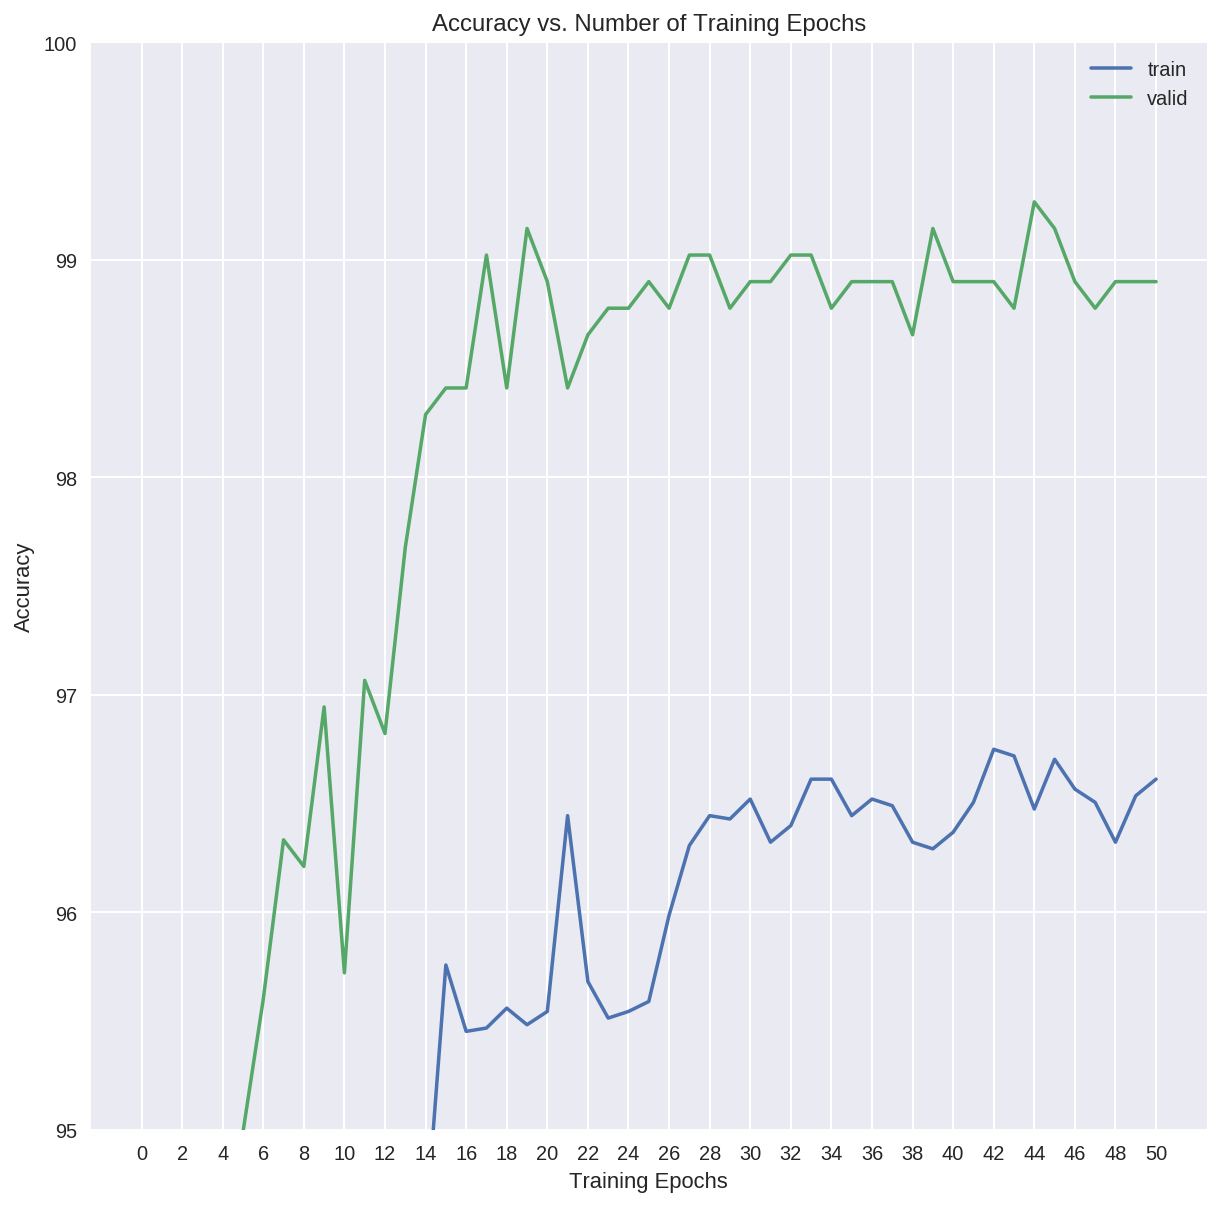

In [0]:
thist = []
vhist = []

thist = [h.cpu().numpy() for h in train_hist]

vhist = [h.cpu().numpy() for h in valid_hist]

plt.figure(figsize=(10, 10))
plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(0,epochs+1),thist,label="train")
plt.plot(range(0,epochs+1),vhist,label="valid")
plt.ylim((95,100.))
plt.xticks(np.arange(0, epochs+1, 2.0))
plt.legend()
plt.show()

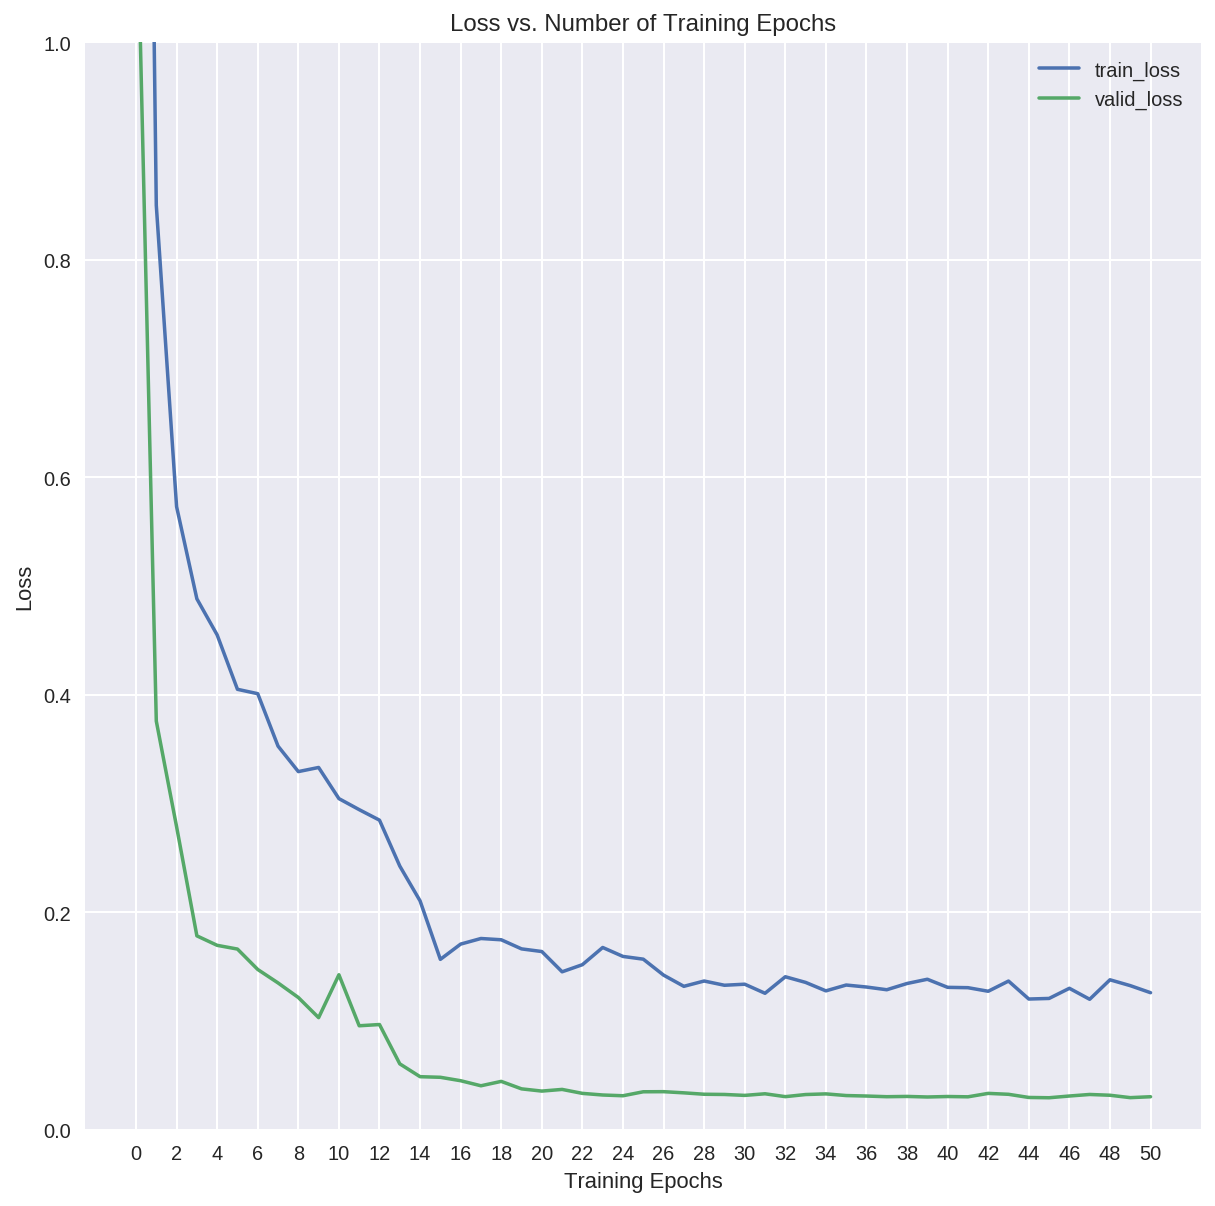

In [0]:
t_loss_hist = []
v_loss_hist = []

t_loss_hist = [h for h in train_loss_history]

v_loss_hist = [h for h in valid_loss_history]

plt.figure(figsize=(10, 10))
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(0,epochs+1),t_loss_hist,label="train_loss")
plt.plot(range(0,epochs+1),v_loss_hist,label="valid_loss")
plt.ylim((0,1))
plt.xticks(np.arange(0, epochs+1, 2.0))
plt.legend()
plt.show()

In [0]:
validate(model)

Test Set
Test Set Error: 0.024
Test Set Accuracy: 99.399


(0.02401763587616957, tensor(0.9940, device='cuda:0'))

In [0]:
validate(model_loss)

Test Set
Test Set Error: 0.024
Test Set Accuracy: 99.279


(0.02357794537853736, tensor(0.9928, device='cuda:0'))

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Retrain

In [0]:
from torchvision.models import *
import torch.nn
def create_model(model_name= 'fbresnet200', pretrained=True, num_classes=102, **kwargs):
    global_pool = kwargs.pop('global_pool', 'avg')
    if model_name == 'fbresnet200':
        if pretrained:
            model = fbresnet200(pretrained=True, **kwargs)
            # Freeze Convolutional weights
            freezed_layers = 0
            for child in model.features.children():
              freezed_layers += 1
              if freezed_layers < 6:
                for param in child.parameters():
                  param.requires_grad = False
            model.reset_fc(num_classes, global_pool=global_pool)
            # Freeze Convolutional weights
            #freezed_layers = 0
            #for child in model.children():
            #  freezed_layers += 1
            #  if freezed_layers < 5:
            #    for param in child.parameters():
            #      param.requires_grad = False
    else:
        assert False and "Invalid model"
    return model


In [0]:
model = create_model(
       'fbresnet200',
        pretrained=True,
        num_classes=102,
        drop_rate=0,
        global_pool='avgmaxc')

model_save_name = 'checkpoint_resnet200_train_v0.pth'
path = F"/content/gdrive/My Drive/{model_save_name}" 
model.load_state_dict(torch.load(path)) 

feature_extract = True
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
            
model_loss = create_model(
       'fbresnet200',
        pretrained=True,
        num_classes=102,
        drop_rate=0,
        global_pool='avgmaxc')

criterion = nn.NLLLoss()
optimizer = optim.Adam(params_to_update, lr=0.00001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model_loss = model_loss.to(device)

model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1211: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://www.dropbox.com/s/tchq8fbdd4wabjx/fbresnet_200-37304a01b.pth?dl=1" to /root/.torch/models/fbresnet_200-37304a01b.pth
259905416it [00:10, 25463940.67it/s]


Params to learn:
	 features.5.0.0.0.0.weight
	 features.5.0.0.0.0.bias
	 features.5.0.0.0.2.weight
	 features.5.0.0.0.2.bias
	 features.5.0.0.0.3.weight
	 features.5.0.0.0.3.bias
	 features.5.0.0.0.5.weight
	 features.5.0.0.0.5.bias
	 features.5.0.0.0.6.weight
	 features.5.0.0.0.6.bias
	 features.5.0.0.0.8.weight
	 features.5.0.0.0.8.bias
	 features.5.0.0.1.0.weight
	 features.5.0.0.1.0.bias
	 features.5.0.0.1.1.weight
	 features.5.0.0.1.1.bias
	 features.5.1.0.0.0.weight
	 features.5.1.0.0.0.bias
	 features.5.1.0.0.2.weight
	 features.5.1.0.0.2.bias
	 features.5.1.0.0.3.weight
	 features.5.1.0.0.3.bias
	 features.5.1.0.0.5.weight
	 features.5.1.0.0.5.bias
	 features.5.1.0.0.6.weight
	 features.5.1.0.0.6.bias
	 features.5.1.0.0.8.weight
	 features.5.1.0.0.8.bias
	 features.5.2.0.0.0.weight
	 features.5.2.0.0.0.bias
	 features.5.2.0.0.2.weight
	 features.5.2.0.0.2.bias
	 features.5.2.0.0.3.weight
	 features.5.2.0.0.3.bias
	 features.5.2.0.0.5.weight
	 features.5.2.0.0.5.bias
	 features.

ResNet200(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Sequential(
        (0): LambdaMap(
          (0): Sequential(
            (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): ReLU()
            (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (7): ReLU()
            (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
         

In [0]:
def train_model(model, model_loss, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_model_wts_loss = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 0.55
    best_acc_loss = 0.0
    best_loss_acc = 0.0
   
    valid_acc_history = []
    valid_loss_history = []
    train_acc_history = []
    train_loss_history = []
    
    
    model_save_name = 'checkpoint_resnet200_train_v1_all.pth'
    model_save_loss = 'checkpoint_resnet200_loss_v1_all.pth'
    path = F"/content/gdrive/My Drive/{model_save_name}" 
    path_loss = F"/content/gdrive/My Drive/{model_save_loss}" 
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #scheduler.batch_step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = (running_corrects.double() / dataset_sizes[phase]) * 100
            
             
      
            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc >= best_acc:
              if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_acc_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), path)
              elif epoch_acc == best_acc:
                if epoch_loss < best_acc_loss: 
                  best_acc = epoch_acc
                  best_acc_loss = epoch_loss
                  best_model_wts = copy.deepcopy(model.state_dict())
                  torch.save(model.state_dict(), path)
            if phase == 'valid' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_loss_acc = epoch_acc
                best_model_wts_loss = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), path_loss)
            if phase == 'valid':
                valid_loss_history.append(epoch_loss)
                valid_acc_history.append(epoch_acc)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                
            print('{} Loss: {:.4f} Acc: {:.4f} Best val Acc: {:4f} Best_val_Acc_Loss: {:4f} Best_val_Loss: {:4f} Best_val_Loss_acc: {:4f} '.format(phase, epoch_loss, epoch_acc, best_acc, best_acc_loss, best_loss, best_loss_acc))
                
            

        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val Acc Loss: {:4f}'.format(best_acc_loss))
    print('Best val Loss: {:4f}'.format(best_loss))
    print('Best val Loss Acc: {:4f}'.format(best_loss_acc))
    
    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    model_loss.load_state_dict(best_model_wts_loss)
    return model, model_loss, train_acc_history, valid_acc_history, train_loss_history, valid_loss_history

In [0]:
def validate(model):
    model.eval()
    model.to(device)
    accuracy = 0
    test_error = 0

    for inputs, targets in dataloaders['test']:
        inputs, targets = inputs.to(device), targets.to(device)

        with torch.no_grad():
            output = model.forward(inputs)
        test_error += criterion(output, targets).item()
        ps = torch.exp(output).data

        equality = (targets.data == ps.max(1)[1])
        if(torch.cuda.is_available()):
            accuracy += equality.type_as(torch.cuda.FloatTensor()).mean()
        else:
            accuracy += equality.type_as(torch.FloatTensor()).mean()
    
    test_error = test_error/len(dataloaders['test'])
    test_accuracy = accuracy/len(dataloaders['test'])
                                                
    print("Test Set")
    print("Test Set Error: {:.3f}".format(test_error))
    print("Test Set Accuracy: {:.3f}".format(test_accuracy * 100))
                                 
    return test_error, test_accuracy

In [0]:
epochs = 50
model, model_loss, train_hist, valid_hist, train_loss_history, valid_loss_history = train_model(model, model_loss, criterion, optimizer, scheduler, num_epochs=epochs+1)

Epoch 0/50
----------
train Loss: 0.1922 Acc: 94.5665 Best val Acc: 0.000000 Best_val_Acc_Loss: 0.000000 Best_val_Loss: 0.550000 Best_val_Loss_acc: 0.000000 
valid Loss: 0.0316 Acc: 99.0220 Best val Acc: 99.022005 Best_val_Acc_Loss: 0.031648 Best_val_Loss: 0.031648 Best_val_Loss_acc: 99.022005 

Epoch 1/50
----------
train Loss: 0.1713 Acc: 95.4976 Best val Acc: 99.022005 Best_val_Acc_Loss: 0.031648 Best_val_Loss: 0.031648 Best_val_Loss_acc: 99.022005 
valid Loss: 0.0304 Acc: 98.7775 Best val Acc: 99.022005 Best_val_Acc_Loss: 0.031648 Best_val_Loss: 0.030400 Best_val_Loss_acc: 98.777506 

Epoch 2/50
----------
train Loss: 0.1659 Acc: 95.2991 Best val Acc: 99.022005 Best_val_Acc_Loss: 0.031648 Best_val_Loss: 0.030400 Best_val_Loss_acc: 98.777506 
valid Loss: 0.0309 Acc: 99.1443 Best val Acc: 99.144254 Best_val_Acc_Loss: 0.030930 Best_val_Loss: 0.030400 Best_val_Loss_acc: 98.777506 

Epoch 3/50
----------
train Loss: 0.1636 Acc: 95.5433 Best val Acc: 99.144254 Best_val_Acc_Loss: 0.030930

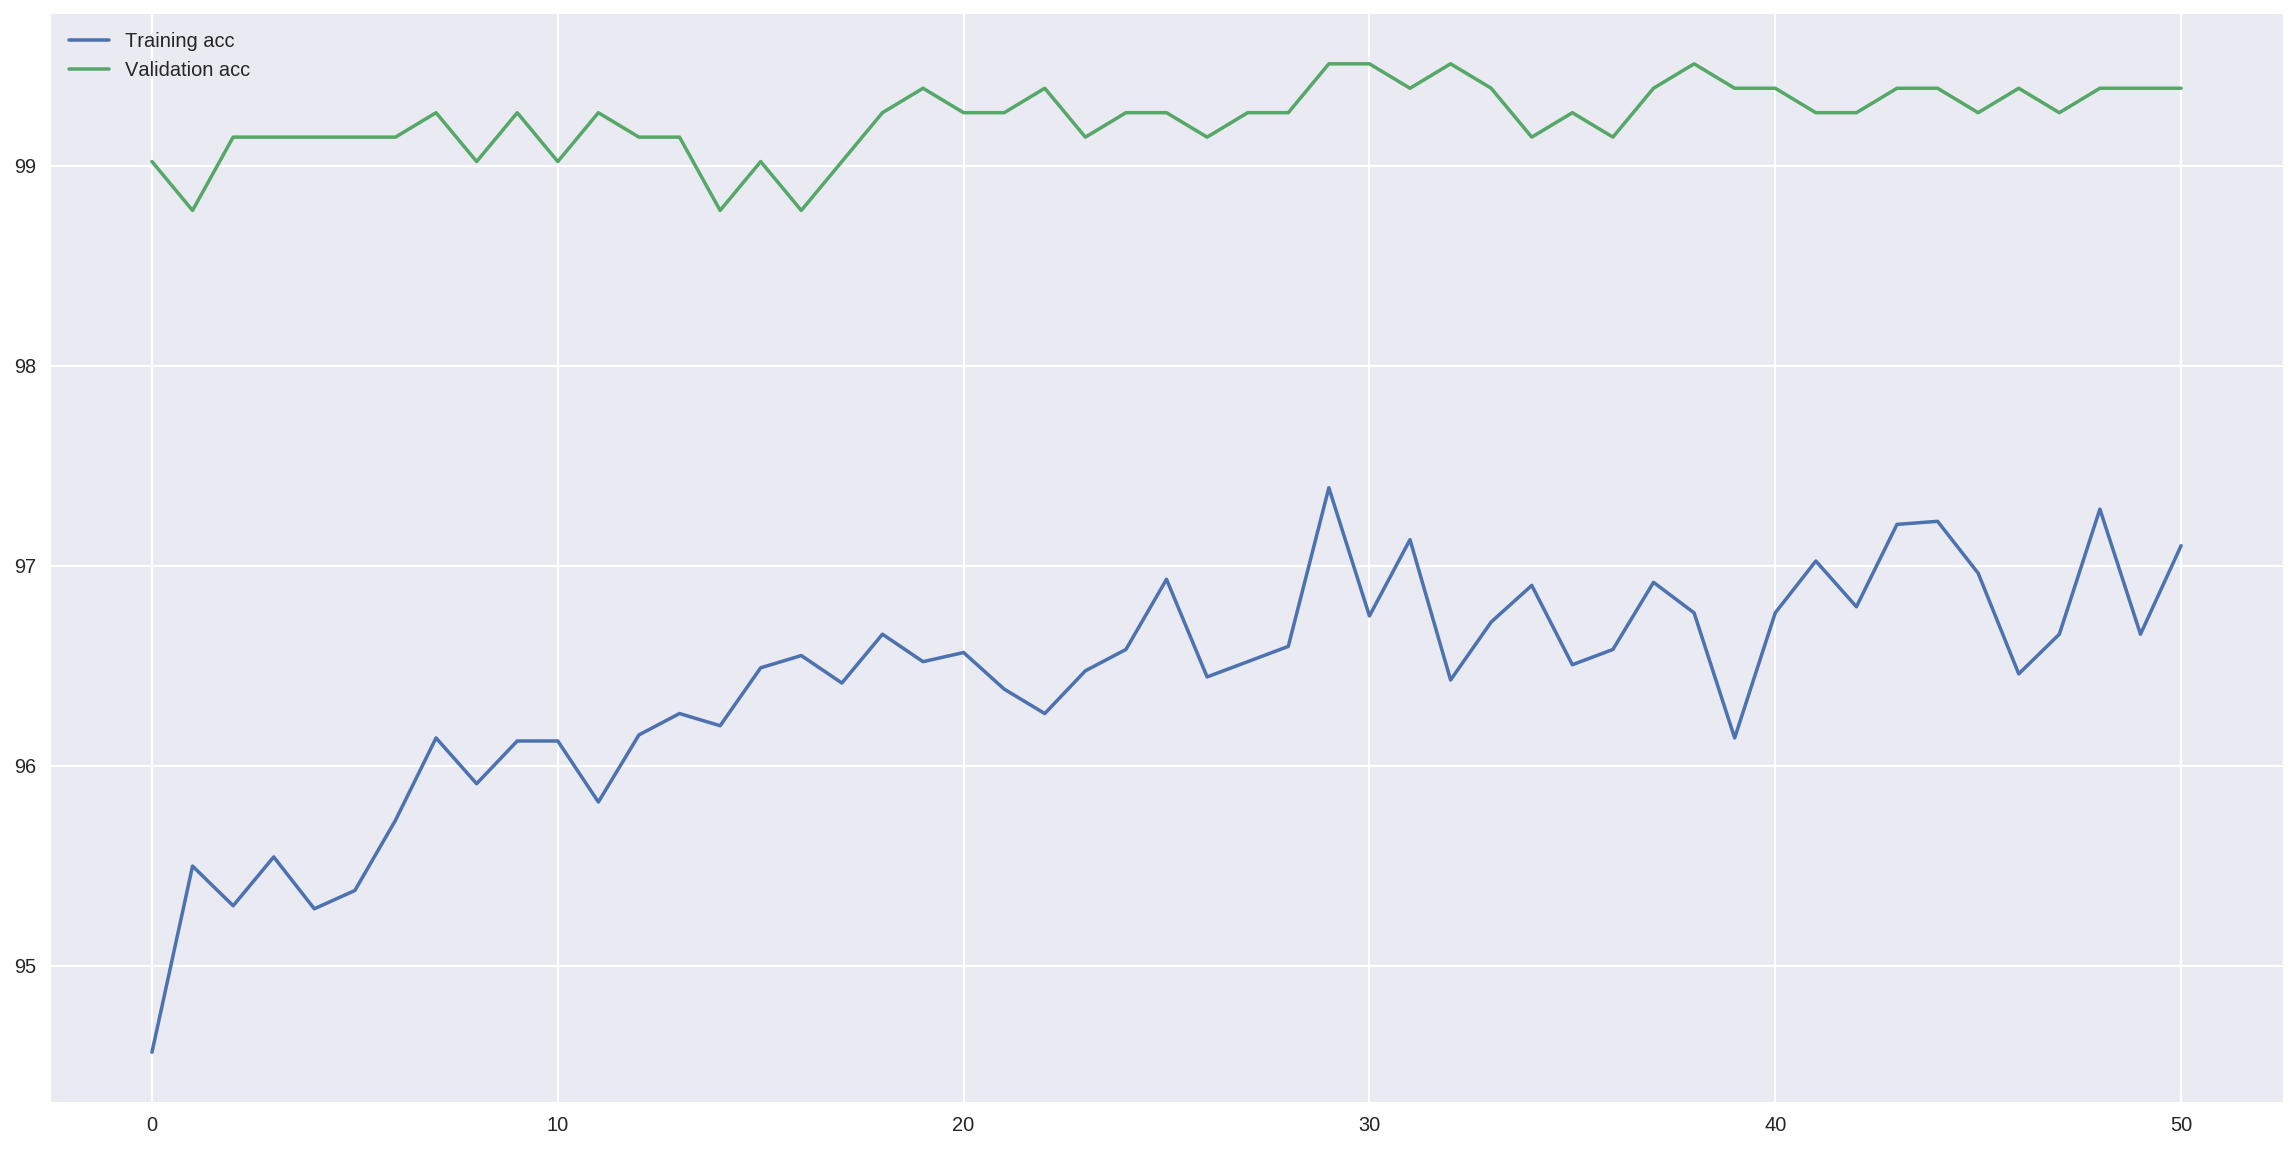

In [0]:
plt.figure(figsize=(20,10))
plt.plot(train_hist, label='Training acc ')
plt.plot(valid_hist, label='Validation acc ')
plt.legend(frameon=False)

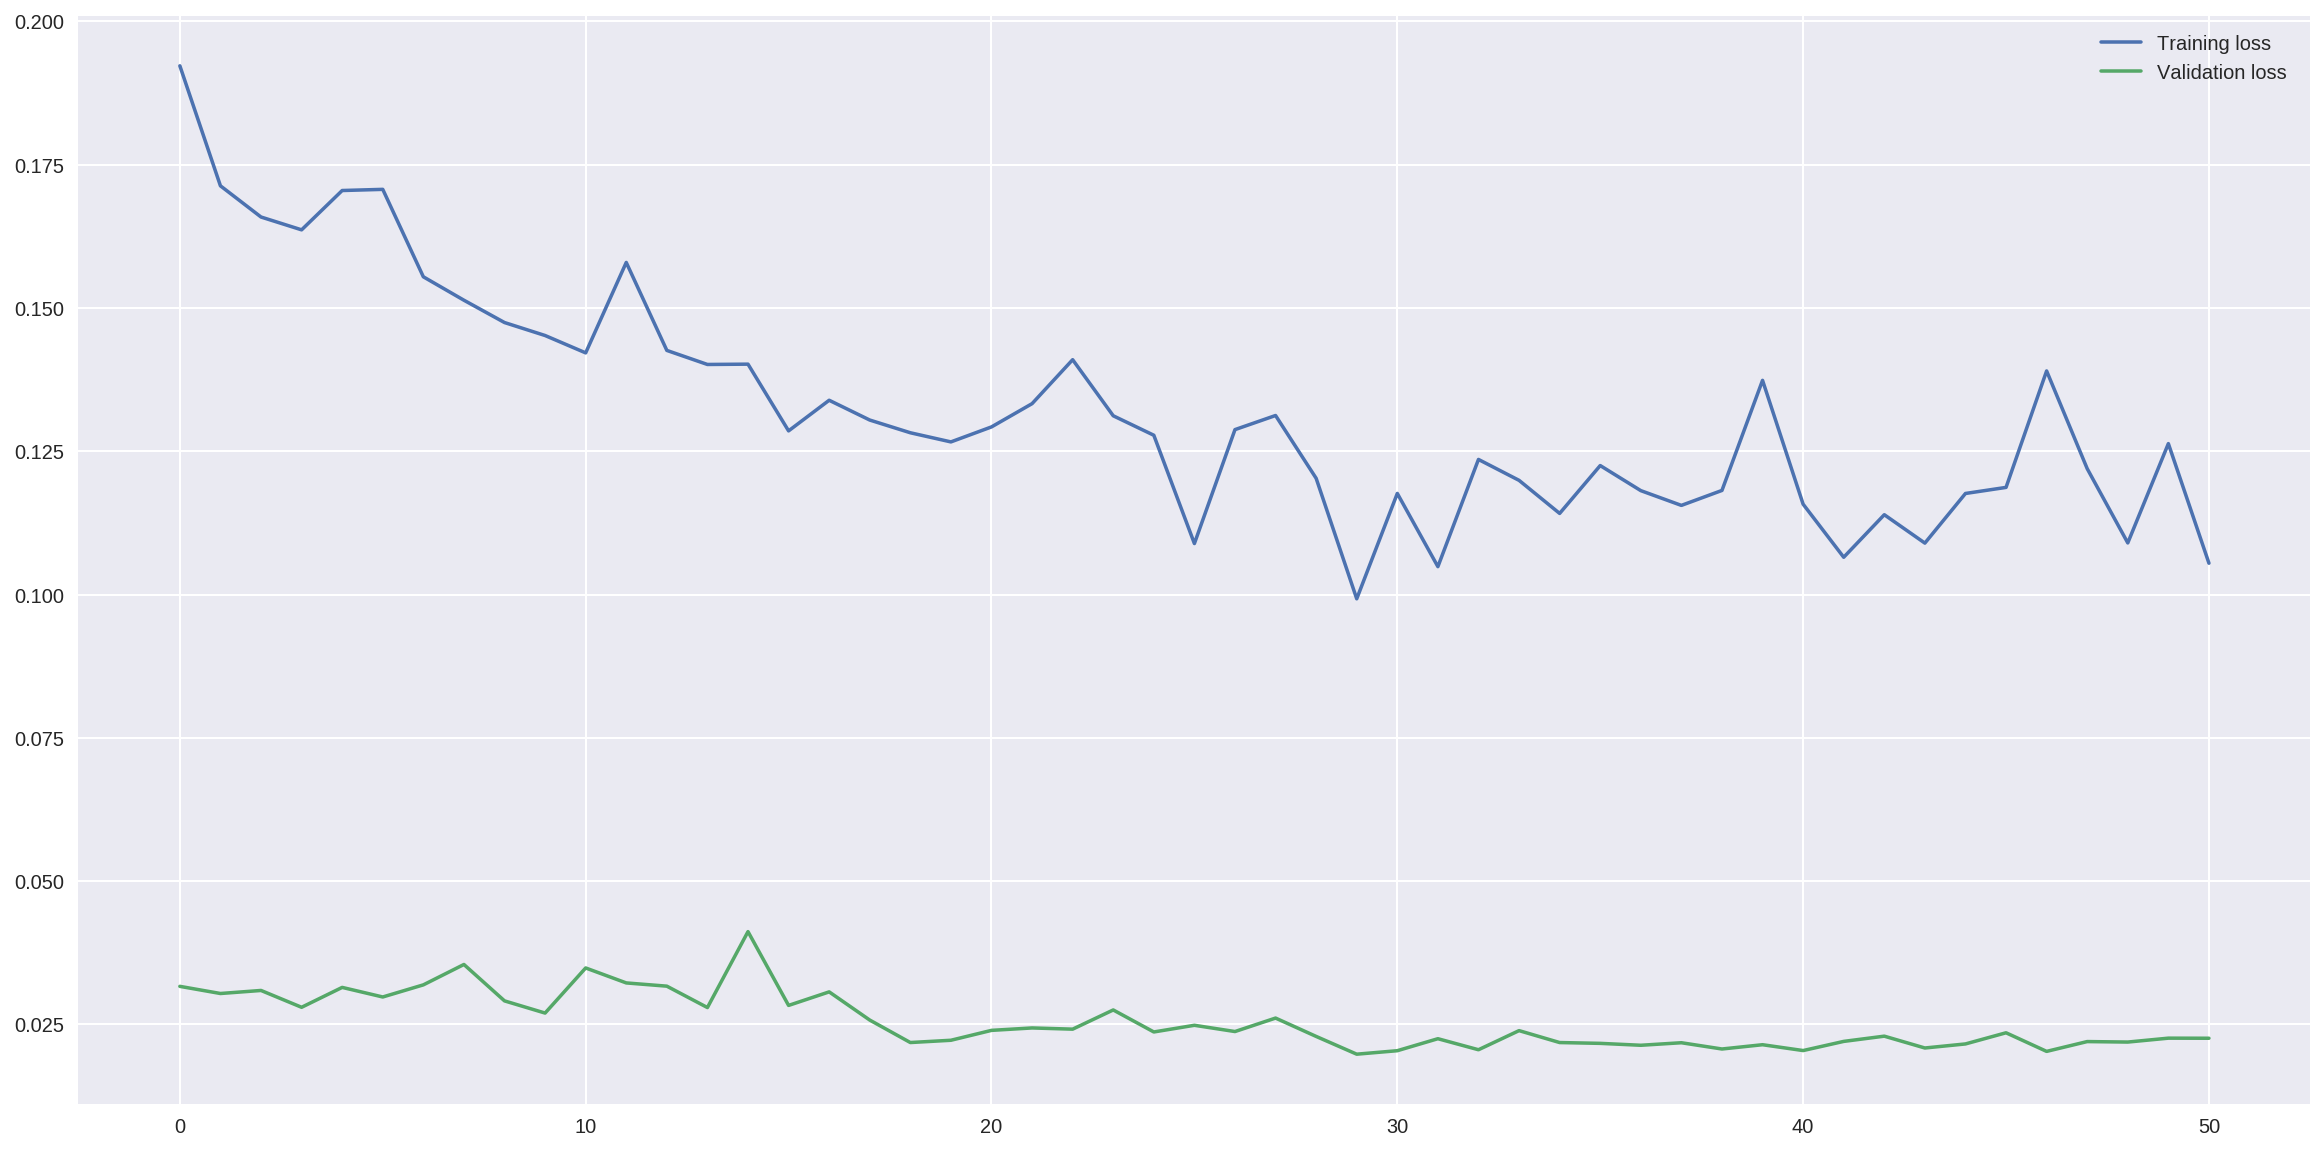

In [0]:
plt.figure(figsize=(20,10))
plt.plot(train_loss_history, label='Training loss')
plt.plot(valid_loss_history, label='Validation loss ')
plt.legend(frameon=False)

In [0]:
validate(model)

Test Set
Test Set Error: 0.019
Test Set Accuracy: 99.639


(0.01915569259570195, tensor(0.9964, device='cuda:0'))

In [0]:
model_save_name = 'checkpoint_resnet200_train_v1_all.pth'
model_save_loss = 'checkpoint_resnet200_loss_v1_all.pth'
path = F"/content/gdrive/My Drive/{model_save_name}" 
path_loss = F"/content/gdrive/My Drive/{model_save_loss}"
model.load_state_dict(torch.load(path))
model_loss.load_state_dict(torch.load(path))

In [0]:
 validate(model_loss)

Test Set
Test Set Error: 0.019
Test Set Accuracy: 99.639


(0.019154079067395566, tensor(0.9964, device='cuda:0'))

## Retrain 2

In [0]:
from torchvision.models import *
import torch.nn
def create_model(model_name= 'fbresnet200', pretrained=True, num_classes=102, **kwargs):
    global_pool = kwargs.pop('global_pool', 'avg')
    if model_name == 'fbresnet200':
        if pretrained:
            model = fbresnet200(pretrained=True, **kwargs)
            # Freeze Convolutional weights
            freezed_layers = 0
            for child in model.features.children():
              freezed_layers += 1
              if freezed_layers < 5:
                for param in child.parameters():
                  param.requires_grad = False
            model.reset_fc(num_classes, global_pool=global_pool)
            # Freeze Convolutional weights
            #freezed_layers = 0
            #for child in model.children():
            #  freezed_layers += 1
            #  if freezed_layers < 5:
            #    for param in child.parameters():
            #      param.requires_grad = False
    else:
        assert False and "Invalid model"
    return model


In [0]:
model = create_model(
       'fbresnet200',
        pretrained=True,
        num_classes=102,
        drop_rate=0,
        global_pool='avgmaxc')

model_save_name = 'checkpoint_resnet200_train_v2_all.pth'
path = F"/content/gdrive/My Drive/{model_save_name}" 
model.load_state_dict(torch.load(path))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1211: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://www.dropbox.com/s/tchq8fbdd4wabjx/fbresnet_200-37304a01b.pth?dl=1" to /root/.torch/models/fbresnet_200-37304a01b.pth
259905416it [05:02, 858534.25it/s] 


In [0]:
model_loss = create_model(
       'fbresnet200',
        pretrained=True,
        num_classes=102,
        drop_rate=0,
        global_pool='avgmaxc')

feature_extract = True
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
            

criterion = nn.NLLLoss()
optimizer = optim.Adam(params_to_update, lr=0.0000005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model_loss = model_loss.to(device)

model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1211: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Params to learn:
	 features.4.0.0.0.0.weight
	 features.4.0.0.0.0.bias
	 features.4.0.0.0.2.weight
	 features.4.0.0.0.2.bias
	 features.4.0.0.0.3.weight
	 features.4.0.0.0.3.bias
	 features.4.0.0.0.5.weight
	 features.4.0.0.0.5.bias
	 features.4.0.0.0.6.weight
	 features.4.0.0.0.6.bias
	 features.4.0.0.0.8.weight
	 features.4.0.0.0.8.bias
	 features.4.0.0.1.0.weight
	 features.4.0.0.1.0.bias
	 features.4.0.0.1.1.weight
	 features.4.0.0.1.1.bias
	 features.4.1.0.0.0.weight
	 features.4.1.0.0.0.bias
	 features.4.1.0.0.2.weight
	 features.4.1.0.0.2.bias
	 features.4.1.0.0.3.weight
	 features.4.1.0.0.3.bias
	 features.4.1.0.0.5.weight
	 features.4.1.0.0.5.bias
	 features.4.1.0.0.6.weight
	 features.4.1.0.0.6.bias
	 features.4.1.0.0.8.weight
	 features.4.1.0.0.8.bias
	 features.4.2.0.0.0.weight
	 features.4.2.0.0.0.bias
	 features.4.2.0.0.2.weight
	 features.4.2.0.0.2.bias
	 features.4.2.0.0.3.weight
	 features.4.2.0.0.3.bias
	 features.4.2.0.0.5.weight
	 features.4.2.0.0.5.bias
	 features.

ResNet200(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Sequential(
        (0): LambdaMap(
          (0): Sequential(
            (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): ReLU()
            (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (7): ReLU()
            (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
         

In [0]:
model = create_model(
       'fbresnet200',
        pretrained=True,
        num_classes=102,
        drop_rate=0,
        global_pool='avgmaxc')

model_save_name = 'checkpoint_resnet200_train_v1_all.pth'
path = F"/content/gdrive/My Drive/{model_save_name}" 
model.load_state_dict(torch.load(path)) 

feature_extract = True
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
            
model_loss = create_model(
       'fbresnet200',
        pretrained=True,
        num_classes=102,
        drop_rate=0,
        global_pool='avgmaxc')

criterion = nn.NLLLoss()
optimizer = optim.Adam(params_to_update, lr=0.0000005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model_loss = model_loss.to(device)

model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1211: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Params to learn:
	 features.4.0.0.0.0.weight
	 features.4.0.0.0.0.bias
	 features.4.0.0.0.2.weight
	 features.4.0.0.0.2.bias
	 features.4.0.0.0.3.weight
	 features.4.0.0.0.3.bias
	 features.4.0.0.0.5.weight
	 features.4.0.0.0.5.bias
	 features.4.0.0.0.6.weight
	 features.4.0.0.0.6.bias
	 features.4.0.0.0.8.weight
	 features.4.0.0.0.8.bias
	 features.4.0.0.1.0.weight
	 features.4.0.0.1.0.bias
	 features.4.0.0.1.1.weight
	 features.4.0.0.1.1.bias
	 features.4.1.0.0.0.weight
	 features.4.1.0.0.0.bias
	 features.4.1.0.0.2.weight
	 features.4.1.0.0.2.bias
	 features.4.1.0.0.3.weight
	 features.4.1.0.0.3.bias
	 features.4.1.0.0.5.weight
	 features.4.1.0.0.5.bias
	 features.4.1.0.0.6.weight
	 features.4.1.0.0.6.bias
	 features.4.1.0.0.8.weight
	 features.4.1.0.0.8.bias
	 features.4.2.0.0.0.weight
	 features.4.2.0.0.0.bias
	 features.4.2.0.0.2.weight
	 features.4.2.0.0.2.bias
	 features.4.2.0.0.3.weight
	 features.4.2.0.0.3.bias
	 features.4.2.0.0.5.weight
	 features.4.2.0.0.5.bias
	 features.

ResNet200(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Sequential(
        (0): LambdaMap(
          (0): Sequential(
            (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): ReLU()
            (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (7): ReLU()
            (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
         

In [0]:
def train_model(model, model_loss, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_model_wts_loss = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 0.55
    best_acc_loss = 0.0
    best_loss_acc = 0.0
   
    valid_acc_history = []
    valid_loss_history = []
    train_acc_history = []
    train_loss_history = []
    
    
    model_save_name = 'checkpoint_resnet200_train_v2_all.pth'
    model_save_loss = 'checkpoint_resnet200_loss_v2_all.pth'
    path = F"/content/gdrive/My Drive/{model_save_name}" 
    path_loss = F"/content/gdrive/My Drive/{model_save_loss}" 
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #scheduler.batch_step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = (running_corrects.double() / dataset_sizes[phase]) * 100
            
             
      
            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc >= best_acc:
              if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_acc_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), path)
              elif epoch_acc == best_acc:
                if epoch_loss < best_acc_loss: 
                  best_acc = epoch_acc
                  best_acc_loss = epoch_loss
                  best_model_wts = copy.deepcopy(model.state_dict())
                  torch.save(model.state_dict(), path)
            if phase == 'valid' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_loss_acc = epoch_acc
                best_model_wts_loss = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), path_loss)
            if phase == 'valid':
                valid_loss_history.append(epoch_loss)
                valid_acc_history.append(epoch_acc)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                
            print('{} Loss: {:.4f} Acc: {:.4f} Best val Acc: {:4f} Best_val_Acc_Loss: {:4f} Best_val_Loss: {:4f} Best_val_Loss_acc: {:4f} '.format(phase, epoch_loss, epoch_acc, best_acc, best_acc_loss, best_loss, best_loss_acc))
                
            

        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val Acc Loss: {:4f}'.format(best_acc_loss))
    print('Best val Loss: {:4f}'.format(best_loss))
    print('Best val Loss Acc: {:4f}'.format(best_loss_acc))
    
    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    model_loss.load_state_dict(best_model_wts_loss)
    return model, model_loss, train_acc_history, valid_acc_history, train_loss_history, valid_loss_history

In [0]:
epochs = 50
model, model_loss, train_hist, valid_hist, train_loss_history, valid_loss_history = train_model(model, model_loss, criterion, optimizer, scheduler, num_epochs=epochs+1)

Epoch 0/50
----------
train Loss: 0.1195 Acc: 96.8864 Best val Acc: 0.000000 Best_val_Acc_Loss: 0.000000 Best_val_Loss: 0.550000 Best_val_Loss_acc: 0.000000 
valid Loss: 0.0289 Acc: 99.0220 Best val Acc: 99.022005 Best_val_Acc_Loss: 0.028886 Best_val_Loss: 0.028886 Best_val_Loss_acc: 99.022005 

Epoch 1/50
----------
train Loss: 0.1403 Acc: 96.2149 Best val Acc: 99.022005 Best_val_Acc_Loss: 0.028886 Best_val_Loss: 0.028886 Best_val_Loss_acc: 99.022005 
valid Loss: 0.0299 Acc: 98.8998 Best val Acc: 99.022005 Best_val_Acc_Loss: 0.028886 Best_val_Loss: 0.028886 Best_val_Loss_acc: 99.022005 

Epoch 2/50
----------
train Loss: 0.1382 Acc: 96.3828 Best val Acc: 99.022005 Best_val_Acc_Loss: 0.028886 Best_val_Loss: 0.028886 Best_val_Loss_acc: 99.022005 
valid Loss: 0.0211 Acc: 99.3888 Best val Acc: 99.388753 Best_val_Acc_Loss: 0.021129 Best_val_Loss: 0.021129 Best_val_Loss_acc: 99.388753 

Epoch 3/50
----------
train Loss: 0.1390 Acc: 96.3217 Best val Acc: 99.388753 Best_val_Acc_Loss: 0.021129

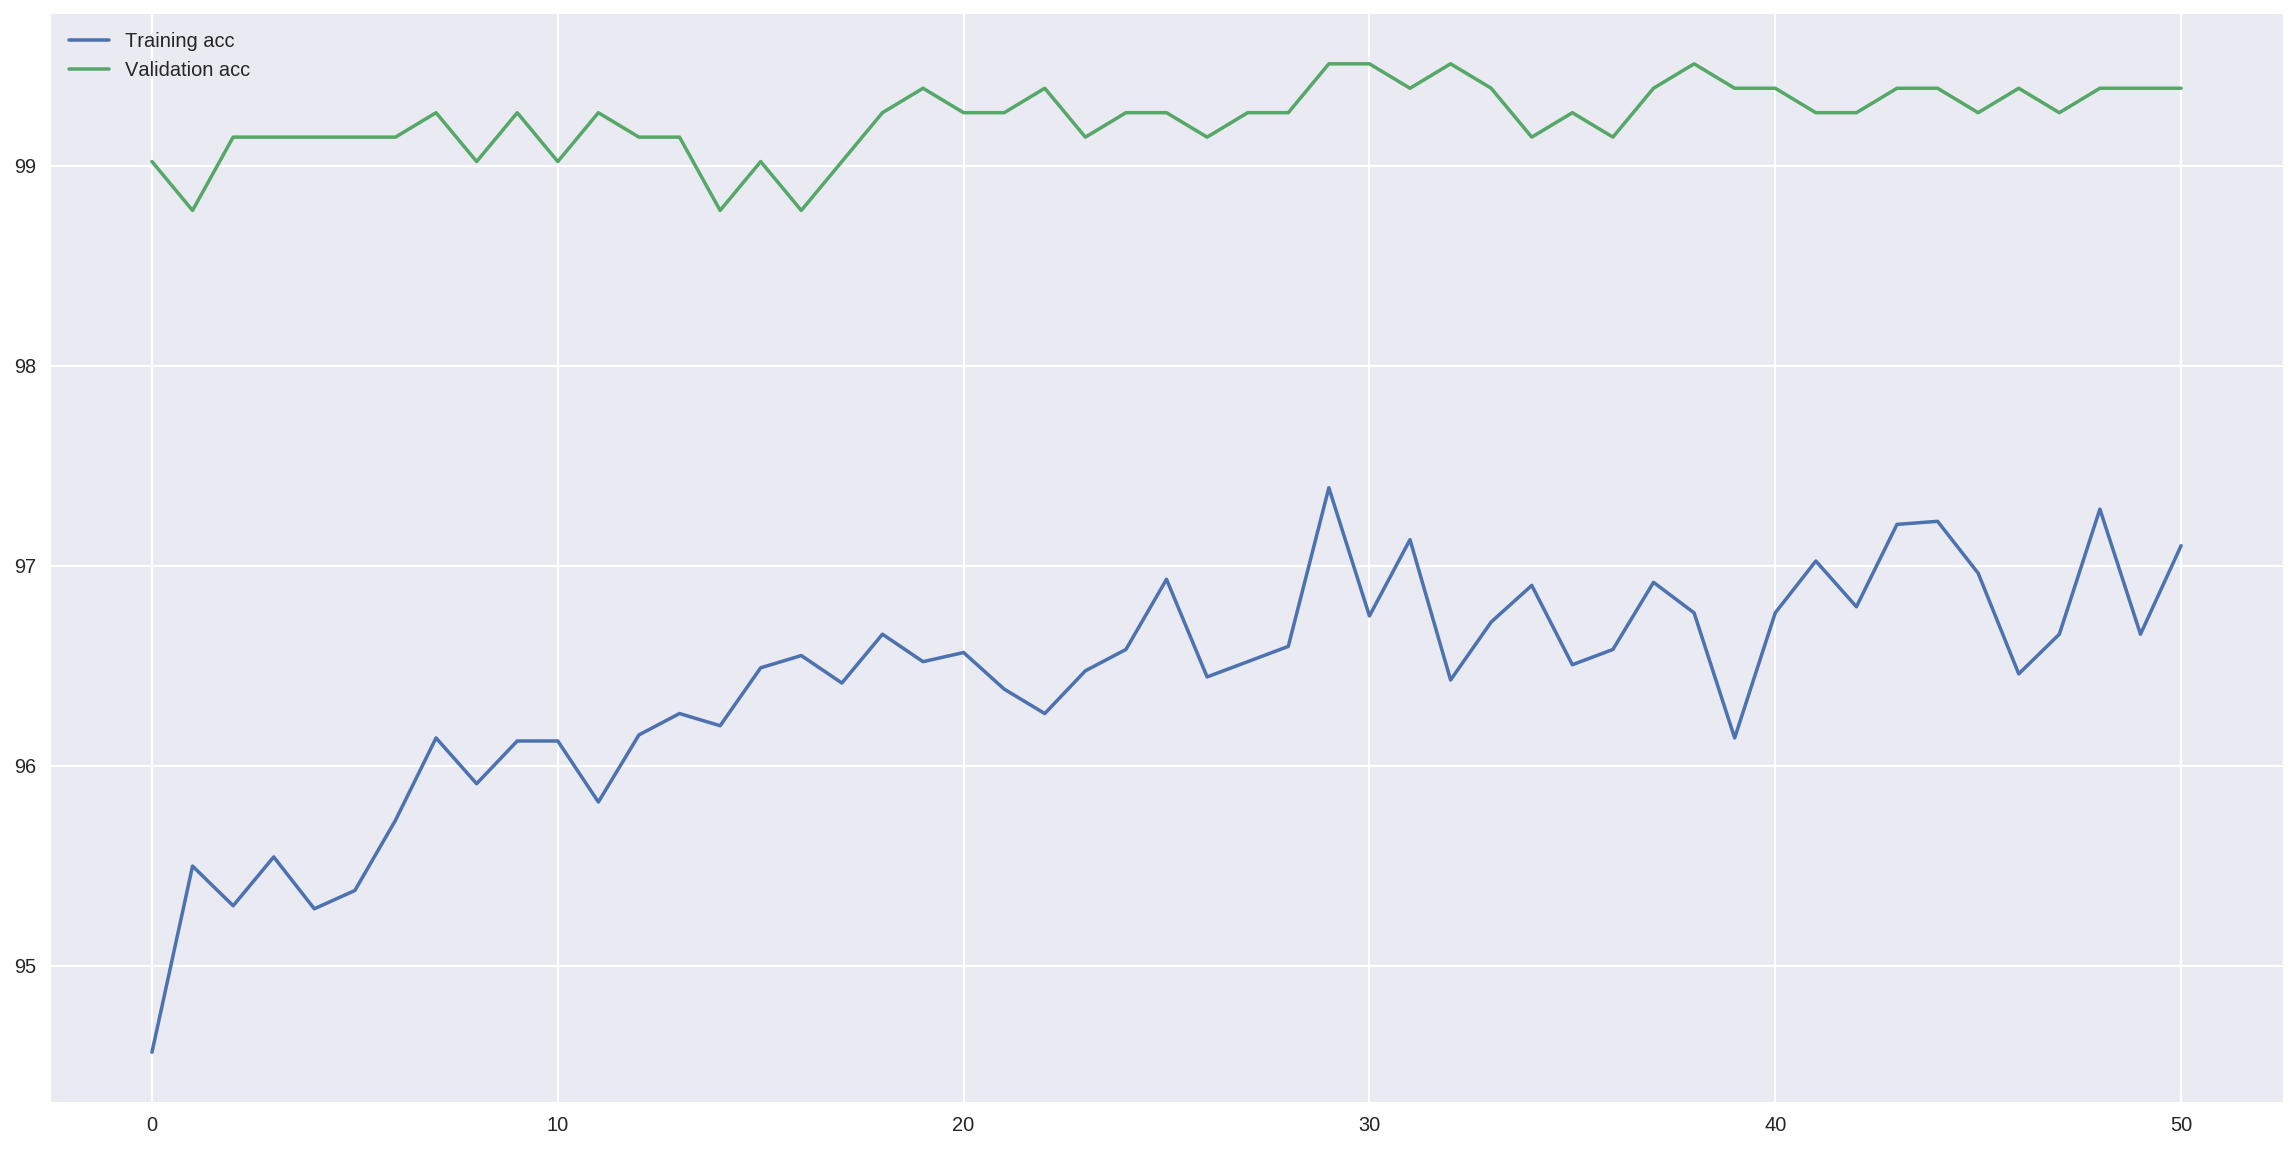

In [0]:
plt.figure(figsize=(20,10))
plt.plot(train_hist, label='Training acc ')
plt.plot(valid_hist, label='Validation acc ')
plt.legend(frameon=False)

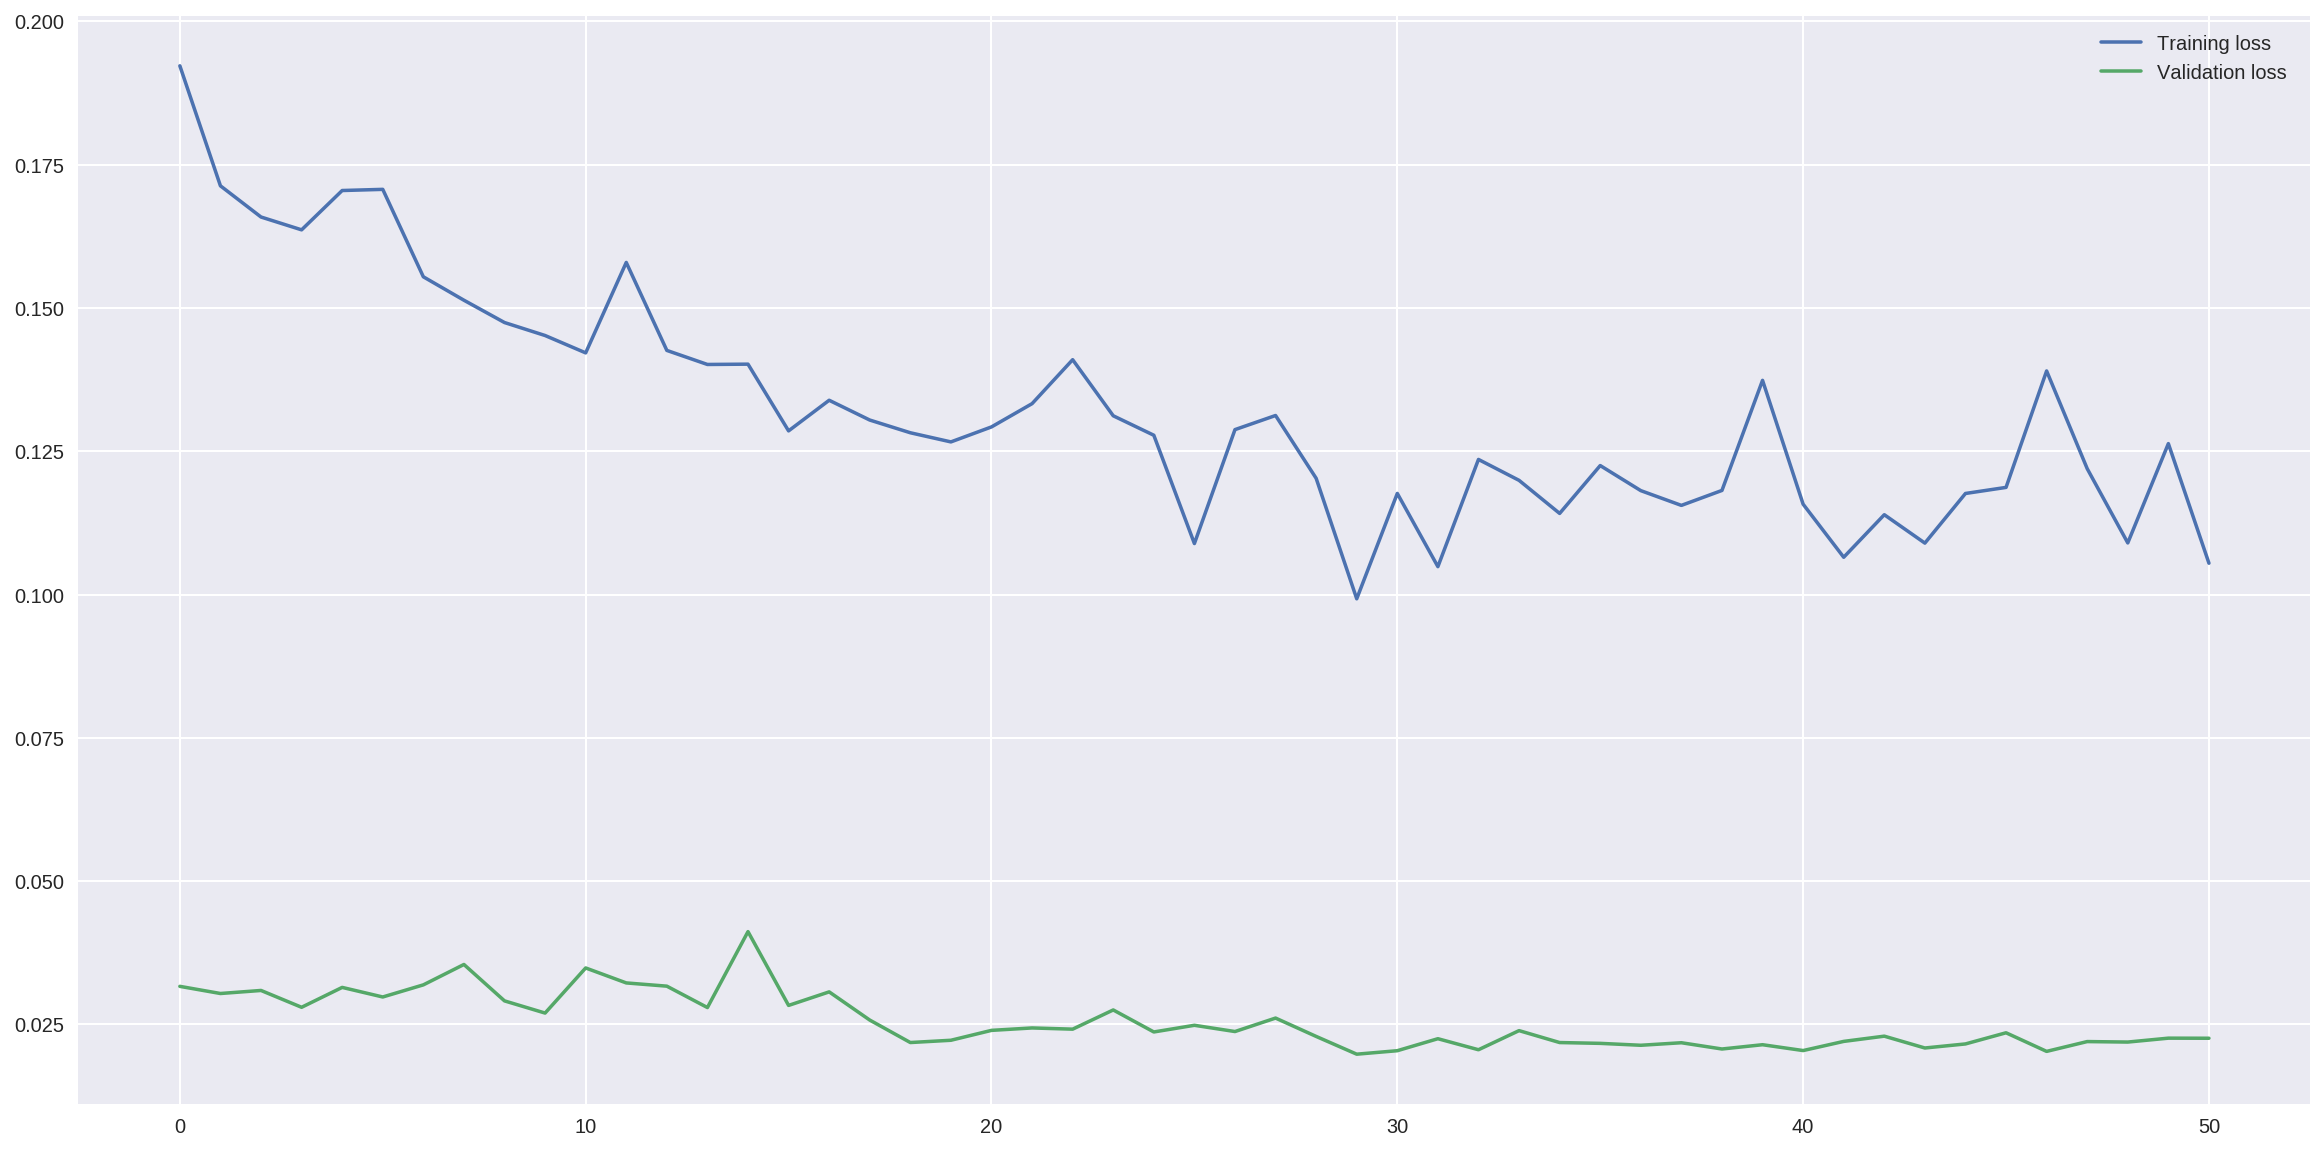

In [0]:
plt.figure(figsize=(20,10))
plt.plot(train_loss_history, label='Training loss')
plt.plot(valid_loss_history, label='Validation loss ')
plt.legend(frameon=False)

In [0]:
validate(model)

Test Set
Test Set Error: 0.012
Test Set Accuracy: 99.880


(0.011858527859046192, tensor(0.9988, device='cuda:0'))

In [0]:
model_save_name = 'checkpoint_resnet200_loss_v2_all.pth'
path = F"/content/gdrive/My Drive/{model_save_name}" 
model_loss.load_state_dict(torch.load(path)) 

In [0]:
 validate(model_loss)

Test Set
Test Set Error: 0.012
Test Set Accuracy: 99.880


(0.01187012019867185, tensor(0.9988, device='cuda:0'))

In [0]:
idx_to_class = {v: k for k, v in image_datasets['train'].class_to_idx.items()}

In [0]:
test_loss_sum = 0.0
test_correct_count = 0.0

##################    
# test the model #
##################
testing_start_time = time.time()
print("Testing...")


model.eval()   


model.cuda()

num_batches = math.ceil(len(dataloaders['test'].dataset) / batch_size)

for batch_idx, (images, labels) in enumerate(dataloaders['test']):

    
    images, labels = images.cuda(), labels.cuda()

    with torch.set_grad_enabled(False):
        outputs = model(images)  # batch_size x 102
        loss = criterion(outputs, labels)  # Average loss value over batch.

    test_loss_sum += loss.item() * images.size(0)

    _, predicted_labels = torch.max(outputs, -1)
    test_correct_count += (predicted_labels == labels).double().sum().item()

    for i in range(len(labels.data)):
        if labels[i] != predicted_labels[i]:
            print( " truth =", idx_to_class[labels[i].item()]," predicted =", idx_to_class[predicted_labels[i].item()])

    progress = (batch_idx+1) * 100.0 / num_batches
    


testing_end_time = time.time()

############################
# calculate average losses #
############################
test_loss = test_loss_sum / len(dataloaders['test'].dataset)
test_acc = test_correct_count / len(dataloaders['test'].dataset)

print('Testing Loss={:.6f}  Testing Accuracy={:.6f}  Duration={:.2f}'.format(test_loss, 
                                                                             test_acc, 
                                                                             testing_end_time - testing_start_time))



Testing...
 truth = 97  predicted = 96
Testing Loss=0.012047  Testing Accuracy=0.998779  Duration=36.53
